# 데이터 다운 및 초기 탐색

## 파일 다운 및 개수 확인

In [152]:
import os
import json
import glob
from tqdm import tqdm  # 진행 상황 표시
from collections import defaultdict, Counter
import pandas as pd # 분석을 위해 pandas 사용
import matplotlib.pyplot as plt
import seaborn as sns

base_dir = r"C:\Users\daboi\OneDrive\Desktop\ai05-level1-project"

train_img_dir = os.path.join(base_dir, "train_images")
test_img_dir = os.path.join(base_dir, "test_images")
train_ann_dir = os.path.join(base_dir, "train_annotations")

# train_annotations 폴더 및 모든 하위 폴더에서 .json 파일 검색
json_files = glob.glob(os.path.join(train_ann_dir, "**", "*.json"), recursive = True)
print(f"총 {len(json_files)}개의 JSON 어노테이션 파일")

# train_images 폴더의 모든 이미지 파일 목록 수집
all_train_img_files = {f for f in os.listdir(train_img_dir) if not f.startswith('.')}
print(f"총 {len(all_train_img_files)}개의 학습 이미지 파일")
print(f"총 {len(os.listdir(test_img_dir))}개의 테스트 이미지 파일")

총 4526개의 JSON 어노테이션 파일
총 1489개의 학습 이미지 파일
총 843개의 테스트 이미지 파일


- 4526개의 어노테이션이 있다 학습 이미지 파일은 1489개이다 이미지 하나에 여러 알약이 있다는 뜻이겠다(이미지를 대략적으로 직접 봐도 대부분 3 - 4개씩 있었다)
- 테스트 이미지는 원래 어노테이션이 없다

In [153]:
# 샘플 JSON 구조 확인
folder = r"C:\Users\daboi\OneDrive\Desktop\ai05-level1-project\train_annotations\K-003483-022347-027777-036637_json\K-003483"

sample_json = r"C:\Users\daboi\OneDrive\Desktop\ai05-level1-project\train_annotations\K-003483-022347-027777-036637_json\K-003483\K-003483-022347-027777-036637_0_2_0_2_70_000_200.json"

# annotation 구조 확인
with open(json_files[0], 'r') as f:
    data = json.load(f)
print(data.keys())
data

dict_keys(['images', 'type', 'annotations', 'categories'])


{'images': [{'file_name': 'K-001900-010224-016551-031705_0_2_0_2_70_000_200.png',
   'width': 976,
   'height': 1280,
   'imgfile': 'K-001900-010224-016551-031705_0_2_0_2_70_000_200.png',
   'drug_N': 'K-001900',
   'drug_S': '정상알약',
   'back_color': '연회색 배경',
   'drug_dir': '앞면',
   'light_color': '주백색',
   'camera_la': 70,
   'camera_lo': 0,
   'size': 200,
   'dl_idx': '1899',
   'dl_mapping_code': 'K-001900',
   'dl_name': '보령부스파정 5mg',
   'dl_name_en': 'Buspar Tab. 5mg Boryung',
   'img_key': 'http://connectdi.com/design/img/drug/1Mxwka5v0lL.jpg',
   'dl_material': '부스피론염산염',
   'dl_material_en': 'Buspirone Hydrochloride',
   'dl_custom_shape': '정제, 저작정',
   'dl_company': '보령제약(주)',
   'dl_company_en': 'Boryung',
   'di_company_mf': '',
   'di_company_mf_en': '',
   'item_seq': 198700706,
   'di_item_permit_date': '19870323',
   'di_class_no': '[01170]정신신경용제',
   'di_etc_otc_code': '전문의약품',
   'di_edi_code': '641901280,A09302381',
   'chart': '이약은 양면볼록한 장방형의 흰색정제이다',
   'drug_shap

JSON 파일은 COCO 데이터셋 형식이다

In [154]:
import json
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

# 이전에 정의된 json_files 변수를 사용한다고 가정합니다.
# json_files = glob.glob(os.path.join(train_ann_dir, "**", "*.json"), recursive = True)

all_metadata_records = []
processing_errors = 0

# JSON 파일에서 추출할 메타데이터 속성 목록 (images 섹션의 모든 키를 동적으로 추출)
# 첫 번째 JSON 파일에서 모든 가능한 키를 추출하여 컬럼을 동적으로 생성
if json_files:
    with open(json_files[0], 'r', encoding='utf-8') as f:
        sample_data = json.load(f)
        if sample_data and 'images' in sample_data and sample_data['images']:
            # file_name, width, height 등 약 50여개의 모든 속성 키를 추출
            all_possible_keys = list(sample_data['images'][0].keys())
        else:
            all_possible_keys = []
else:
    all_possible_keys = []

# 이미지당 캡처/약물 메타데이터 수집
for json_path in tqdm(json_files, desc="Collecting all metadata"):
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
        if not data.get('images'):
            processing_errors += 1
            continue

        img_info = data['images'][0]
        record = {}
        
        # 1. Image 및 Drug Metadata (약 50개 항목)
        for key in all_possible_keys:
            record[key] = img_info.get(key)
            
        # 2. Annotation Metadata (BBox 정보)
        # 한 JSON 파일에는 여러 개의 BBox가 있을 수 있으므로, 각 BBox마다 레코드를 생성합니다.
        
        if not data.get('annotations'):
             # 어노테이션이 없는 경우도 레코드에 포함 (필요하다면)
             record['bbox'] = None
             record['category_id'] = None
             all_metadata_records.append(record.copy())
             continue


        for ann in data['annotations']:
            # BBox 정보 추가 (리스트 [x, y, w, h]로 저장)
            record['bbox'] = ann['bbox']
            # BBox가 연결된 클래스 ID (dl_idx/dl_mapping_code와는 다름, categories 섹션의 id)
            record['annotation_category_id'] = ann['category_id']
            
            # 딕셔너리를 복사하여 리스트에 추가 (매 BBox마다 하나의 행)
            all_metadata_records.append(record.copy())
            
            
    except Exception as e:
        processing_errors += 1
        # print(f"Error processing {json_path}: {e}")
        continue

# DataFrame으로 변환
metadata_all_pills_df = pd.DataFrame(all_metadata_records)

print("\n" + "=" * 50)
print(f"총 {len(metadata_all_pills_df)}개의 알약/BBox 레코드 수집 완료")
print(f"처리 오류 발생 JSON 파일 수: {processing_errors}개")
print(f"전체 속성(컬럼) 개수: {len(metadata_all_pills_df.columns)}개")

# 데이터프레임의 첫 5행과 모든 컬럼을 출력
print("\n첫 5개 알약 레코드의 모든 메타데이터:")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(metadata_all_pills_df.head().to_string())

# 사용 후 옵션 복원
pd.reset_option('display.max_columns')
pd.reset_option('display.width')


총 4526개의 알약/BBox 레코드 수집 완료
처리 오류 발생 JSON 파일 수: 0개
전체 속성(컬럼) 개수: 52개

첫 5개 알약 레코드의 모든 메타데이터:
                                              file_name  width  height                                               imgfile    drug_N drug_S back_color drug_dir light_color  camera_la  camera_lo  size dl_idx dl_mapping_code        dl_name                    dl_name_en                                                      img_key dl_material           dl_material_en dl_custom_shape dl_company dl_company_en di_company_mf di_company_mf_en   item_seq di_item_permit_date    di_class_no di_etc_otc_code          di_edi_code                  chart drug_shape  thick  leng_long  leng_short print_front print_back color_class1 color_class2 line_front line_back img_regist_ts form_code_name mark_code_front_anal mark_code_back_anal mark_code_front_img mark_code_back_img mark_code_front mark_code_back change_date    id                  bbox  annotation_category_id
0  K-001900-010224-016551-031705_0_2_0_2_70_00

## 데이터 통합

In [155]:
# JSON 파일들을 읽어 하나의 데이터로 통합
master_data = defaultdict(lambda: {
    'image_path': '', 
    'width': 0, 
    'height': 0, 
    'annotations': []
})
class_to_id = {}
current_id = 0
processing_errors = 0

for json_path in json_files:

    with open(json_path, 'r', encoding = 'utf-8') as f:
        data = json.load(f)

    # 이미지 정보 추출
    img_info = data['images'][0]
    img_filename = img_info['file_name']

    # 이미지 경로/크기 저장(이미지 당 1회)
    if not master_data[img_filename]['image_path']:
        image_path = os.path.join(train_img_dir, img_filename)
        master_data[img_filename]['image_path'] = image_path
        master_data[img_filename]['width'] = img_info['width']
        master_data[img_filename]['height'] = img_info['height']

    # 클래스 이름 매핑 준비
    # 이 JSON 파일이 정의하는 카테고리(알약) 정보를 맵으로 만든다
    category_map = {cat['id']: cat['name'] for cat in data['categories']}

    # 어노테이션(BBox) 처리
    for ann in data['annotations']:
        bbox = ann['bbox'] # [x, y, w, h]
            
        # category_id를 사용해 실제 클래스 이름을 찾는다
        ann_cat_id = ann['category_id'] 
            
        if ann_cat_id not in category_map:
            processing_errors += 1
            continue # category_map에 없으면 이 알약(ann)은 건너뛰고 다음 알약으로

        class_name = category_map[ann_cat_id]

        # 클래스 ID 부여
        if class_name not in class_to_id:
            class_to_id[class_name] = current_id
            current_id += 1
                
        class_id = class_to_id[class_name]

        # 최종 어노테이션 추가
        master_data[img_filename]['annotations'].append({
            'class_id': class_id,
            'class_name': class_name, # 이름도 저장해두면 분석에 유용할 것 같다
            'bbox': bbox
        })

print(f"총 {len(master_data)}개의 이미지 데이터 처리")
print(f"총 {len(class_to_id)}개의 고유 클래스(알약 종류) 발견")

# 결과 저장
# 이게 진짜 학습 데이터이다 4526개의 JSON을 1489개의 이미지별 묶음으로 만들었다 이 안에 이미지의 모든 정답이 들어있다
with open(os.path.join(base_dir, "train_master_annotations.json"), "w", encoding = 'utf-8') as f:
    json.dump(master_data, f, ensure_ascii = False, indent = 4)

# 이건 이름(키)와 숫자(value)를 연결해주는 맵이다
with open(os.path.join(base_dir, "class_to_id.json"), "w", encoding = 'utf-8') as f:
    json.dump(class_to_id, f, ensure_ascii = False, indent = 4)
        
print("train_master_annotations.json 파일과 class_to_id.json 파일 저장")

총 1489개의 이미지 데이터 처리
총 73개의 고유 클래스(알약 종류) 발견
train_master_annotations.json 파일과 class_to_id.json 파일 저장


- 1489개의 이미지에 73개의 클래스가 있다
- 사용하기 쉽게 train_master_annotations.json과 class_to_id.json을 만들어 저장했다

## 파일 검증

In [156]:
# 파일 검증 시작
print(f"이미지 파일 총 {len(all_train_img_files)}개")
print(f"JSON 파일 총 {len(json_files)}개")

annotated_img_files = set(master_data.keys()) 

# 이미지 폴더에는 있는데 JSON이 참조하지 않는 이미지
imgs_without_annotations = all_train_img_files - annotated_img_files
print(f"어노테이션이 없는 이미지 수: {len(imgs_without_annotations)} 개")

# JSON은 참조하고 있는데 이미지 폴더에 실물 파일이 없는 경우
annotations_without_imgs = annotated_img_files - all_train_img_files
print(f"이미지가 없는 어노테이션 수: {len(annotations_without_imgs)} 개")

이미지 파일 총 1489개
JSON 파일 총 4526개
어노테이션이 없는 이미지 수: 0 개
이미지가 없는 어노테이션 수: 0 개


파일 검증 부분은 특별하게 결점은 없는 것 같다

## 클래스 분석

In [157]:
# 클래스 분포 분석 시작
# master_data에서 모든 클래스 이름(class_name)을 수집
all_class_names = []
for img_data in master_data.values():
    for ann in img_data['annotations']:
        all_class_names.append(ann['class_name'])

print(f"총 {len(all_class_names)}개의 알약(= 바운딩 박스)")

# 클래스별 개수 카운트
class_counts = Counter(all_class_names)

# DataFrame으로 변환 및 정렬
class_df = pd.DataFrame(class_counts.items(), columns = ['class_name', 'count'])
class_df = class_df.sort_values(by = 'count', ascending = False).reset_index(drop = True)


print(f"(전체 {len(class_df)}개 클래스)")

# 전체 DataFrame 출력
print(class_df.to_string())

총 4526개의 알약(= 바운딩 박스)
(전체 73개 클래스)
                  class_name  count
0         기넥신에프정(은행엽엑스)(수출용)    514
1                일양하이트린정 2mg    240
2                 보령부스파정 5mg    180
3                뮤테란캡슐 100mg    172
4                가바토파정 100mg    143
5              동아가바펜틴정 800mg    139
6               아토젯정 10/40mg    113
7                   리바로정 4mg    111
8                  리피토정 20mg    109
9               로수젯정10/5밀리그램    108
10                크레스토정 20mg    108
11         무코스타정(레바미피드)(비매품)     99
12                플라빅스정 75mg     97
13              트윈스타정 40/5mg     94
14         제미메트서방정 50/1000mg     88
15            자누메트정 50/850mg     88
16              트라젠타정(리나글립틴)     87
17                자누비아정 50mg     85
18     자누메트엑스알서방정 100/1000mg     85
19                 카나브정 60mg     84
20         트라젠타듀오정 2.5/850mg     81
21             엑스포지정 5/160mg     80
22              세비카정 10/40mg     79
23             아모잘탄정 5/100mg     76
24                 노바스크정 5mg     66
25           큐시드정 31.5mg/PTP 

C:\Users\daboi\AppData\Local\Temp\ipykernel_16160\2280442953.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


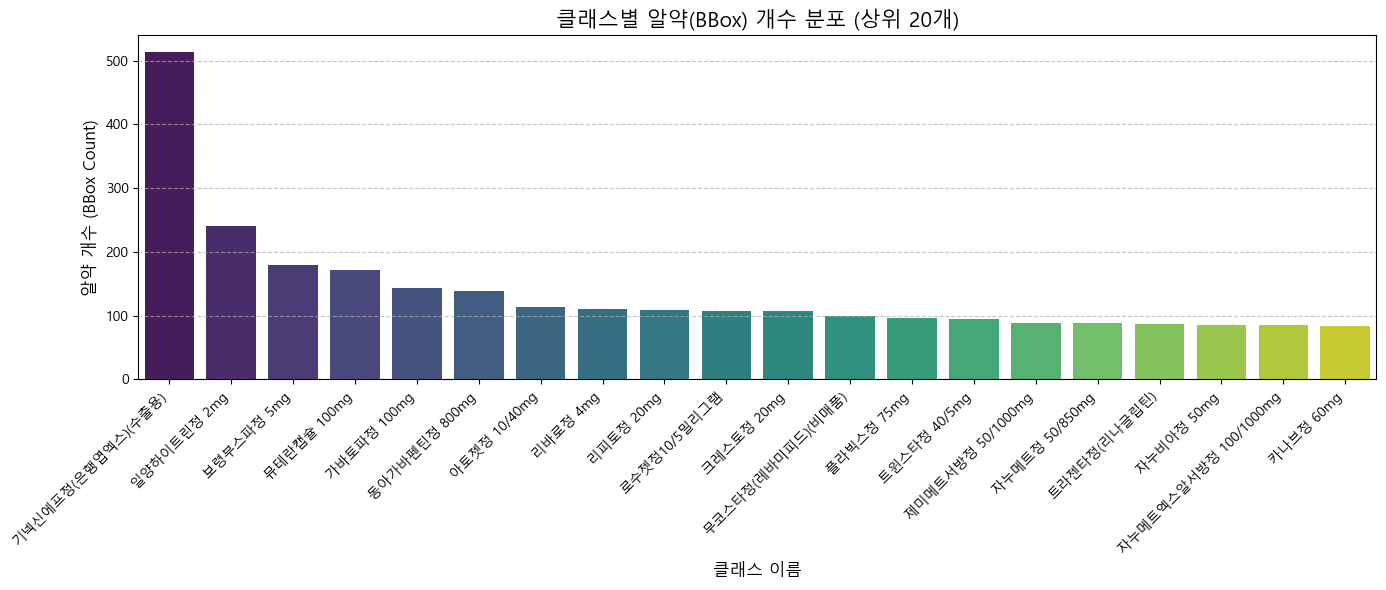

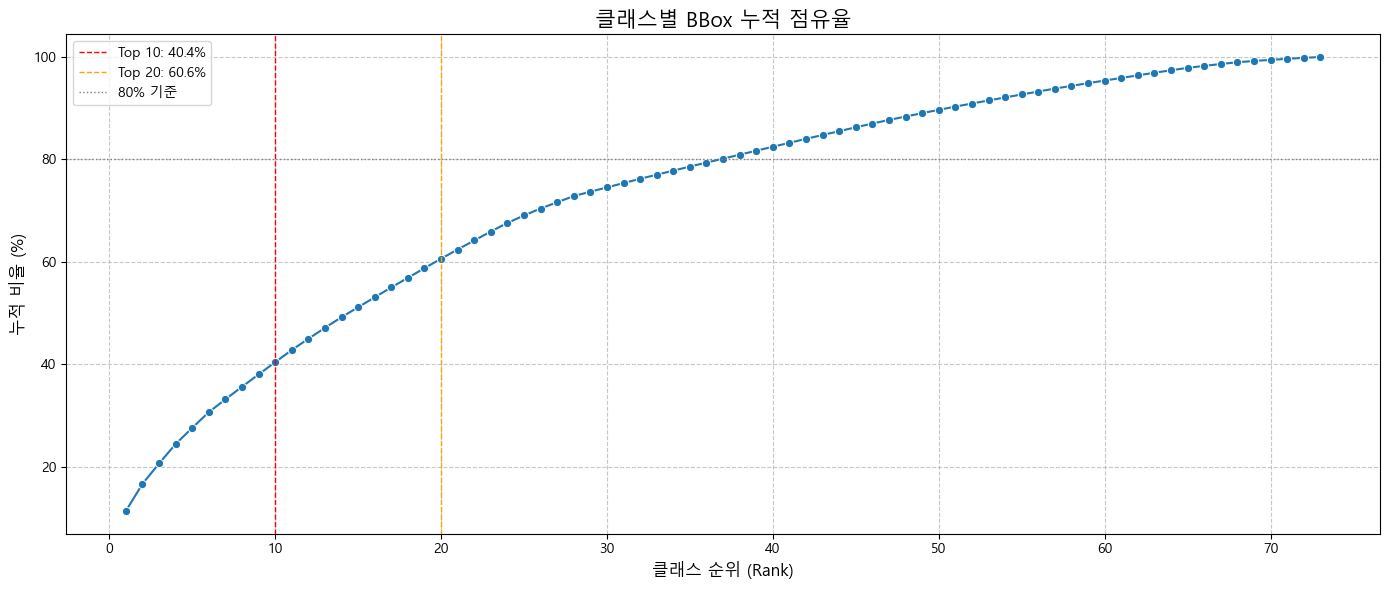

In [ ]:
# 클래스 시각화
# 운영체제에 따라 폰트 경로 설정
import platform
from matplotlib import font_manager, rc

if platform.system() == 'Windows':
    # Windows: Malgun Gothic 설정
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin': # Mac OS
    # Mac OS: Apple Gothic 설정
    rc('font', family='AppleGothic')
else:
    # Linux 또는 기타 OS: 널리 사용되는 Nanum Gothic을 가정하거나, 기본 폰트 사용
    try:
        font_name = font_manager.FontProperties(fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf').get_name()
        rc('font', family=font_name)
    except:
        rc('font', family='DejaVu Sans')

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False 


# 클래스 분포 막대 그래프 (Bar Plot) - (Using 'count')
TOP_N = 20 # 상위 20개 클래스만 시각화

plt.figure(figsize=(14, 6))
sns.barplot(
    x='class_name', 
    y='count',  # 'count' 컬럼 사용
    data=class_df.head(TOP_N), 
    palette='viridis' 
)

plt.title(f'클래스별 알약(BBox) 개수 분포 (상위 {TOP_N}개)', fontsize=15)
plt.xlabel('클래스 이름', fontsize=12)
plt.ylabel('알약 개수 (BBox Count)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('class_distribution_bar_plot_korean.png')
# plt.show()


# 누적 분포 그래프 (Cumulative Distribution Plot) - (Using 'count')
# 전체 데이터 중 상위 클래스가 얼마나 많은 비중을 차지하는지 확인
total_bbox_count = class_df['count'].sum()
class_df['cumulative_count'] = class_df['count'].cumsum()
class_df['cumulative_ratio'] = class_df['cumulative_count'] / total_bbox_count * 100

plt.figure(figsize=(14, 6))
# 누적 비율을 선 그래프로 표시
sns.lineplot(
    x=class_df.index + 1, # 인덱스 + 1 = 순위
    y='cumulative_ratio',
    data=class_df,
    marker='o'
)

# 데이터 불균형의 심각도를 나타내는 주요 지점 표시
top_10_ratio = class_df.iloc[min(9, len(class_df) - 1)]['cumulative_ratio']
top_20_ratio = class_df.iloc[min(19, len(class_df) - 1)]['cumulative_ratio']

plt.axvline(x=10, color='r', linestyle='--', linewidth=1, label=f'Top 10: {top_10_ratio:.1f}%')
plt.axvline(x=20, color='orange', linestyle='--', linewidth=1, label=f'Top 20: {top_20_ratio:.1f}%')
plt.axhline(y=80, color='gray', linestyle=':', linewidth=1, label='80% 기준')

plt.title('클래스별 BBox 누적 점유율', fontsize=15)
plt.xlabel('클래스 순위 (Rank)', fontsize=12)
plt.ylabel('누적 비율 (%)', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('class_cumulative_distribution_plot_korean.png')
# plt.show()

- 클래스 불균형이 심각한 것 같다
- 상위 10개 클래스만 해도 40%는 넘는다
- 데이터 증강은 당연하게 해야될 것 같다
- 클래스 가중치를 조절해주는 방법들을 고려해본다
    - 오버샘플링 (Oversampling)
    - 소수 클래스(예를 들면 50개 이하)는 강하게 증강
    - 클래스 그룹화(극도로 적은 클래스(예: 10개 미만)는 초반에는 묶어서 학습 후, 후반에 세분화)
    - stratified split (클래스 비율 유지)
    - WeightedRandomSampler
    - 손실 함수에서 소수 클래스에 더 큰 가중치를 부여
    - Focal Loss
    - 앙상블 기법 (Ensemble Methods)
    - Two-stage 학습
    - 이외에도 여러 기법을 고려해본다
- 평가 때도 Accuracy 대신 mAP, per-class Recall/Precision 확인하고 Macro-F1, Weighted-F1 같은 지표 활용하는 방법도 고려해본다

In [172]:
# 분석 대상 메타데이터 속성
TARGET_PROPERTIES = ['drug_shape', 'color_class1', 'print_front', 'print_back', 'dl_company_en']

# 클래스별 속성값 저장을 위한 딕셔너리
# Key: 클래스 이름 (dl_name), Value: {속성: [값1, 값2, ...]}
class_metadata_agg = defaultdict(lambda: {prop: [] for prop in TARGET_PROPERTIES})

for json_path in tqdm(json_files, desc = "Processing JSON metadata"):
    try:
        with open(json_path, 'r', encoding = 'utf-8') as f:
            data = json.load(f)
            
        if not data['images']:
            continue

        img_info = data['images'][0]
        
        # 클래스 이름 추출 (dl_name이 실제 알약 이름)
        class_name = img_info.get('dl_name')
        if not class_name:
            continue
            
        # 각 속성값 추출 및 저장
        for prop in TARGET_PROPERTIES:
            value = img_info.get(prop)
            if value is not None:
                class_metadata_agg[class_name][prop].append(value)
                
    except Exception as e:
        # print(f"Error processing {json_path}: {e}")
        continue

# 클래스별 메타데이터 고유값 카운트 분석
analysis_records = []

for class_name, props in class_metadata_agg.items():
    record = {'class_name': class_name}
    
    # 각 속성별 '고유한 값의 개수'를 계산
    for prop, values in props.items():
        # 고유값 개수 = len(set(values))
        record[f'unique_{prop}_count'] = len(set(values))
    
    # 해당 클래스가 전체 데이터셋에서 몇 번 등장했는지 (BBox가 아닌 JSON 파일 수 기준)
    record['json_count'] = len(props['drug_shape']) # 모든 JSON 파일은 drug_shape을 가질 것이므로 이를 기준으로 카운트
    analysis_records.append(record)

# DataFrame으로 변환
metadata_df = pd.DataFrame(analysis_records)

# 클래스 등장 횟수(json_count) 기준으로 내림차순 정렬
metadata_df = metadata_df.sort_values(by = 'json_count', ascending = False)

# 결과 출력 (상위 10개만 예시로 출력)
print("\n")
print("클래스별 메타데이터 고유값 개수 (상위 10개)")
print(metadata_df.head(10).to_string())

# 전체 클래스 메타데이터 분석 결과 CSV 저장 (전체 분석을 위해)
metadata_df.to_csv('class_metadata_uniqueness_analysis.csv', index = False, encoding = 'utf-8')
print("\n'class_metadata_uniqueness_analysis.csv' 파일 저장")

Processing JSON metadata: 100%|██████████| 4526/4526 [00:00<00:00, 13039.77it/s]



클래스별 메타데이터 고유값 개수 (상위 10개)
            class_name  unique_drug_shape_count  unique_color_class1_count  unique_print_front_count  unique_print_back_count  unique_dl_company_en_count  json_count
50  기넥신에프정(은행엽엑스)(수출용)                        1                          1                         1                        1                           1         514
29         일양하이트린정 2mg                        1                          1                         1                        1                           1         240
0           보령부스파정 5mg                        1                          1                         1                        1                           1         180
15         뮤테란캡슐 100mg                        1                          1                         1                        1                           1         172
1        동아가바펜틴정 800mg                        1                          1                         1                        1                

- class_name = 알약의 정식 명칭 (예: '스토가정 10mg')
- unique_drug_shape_count = 해당 알약이 데이터셋 내에서 가진 모양의 고유한 개수
- unique_color_class1_count	= 해당 알약의 주 색상의 고유한 개수
- unique_print_front_count = 알약 앞면에 인쇄된 문자/숫자의 고유한 개수
- unique_print_back_count = 알약 뒷면에 인쇄된 문자/숫자의 고유한 개수
- unique_dl_company_en_count = 알약을 제조한 회사 이름(영문)의 고유한 개수
- json_count = 해당 클래스를 포함하고 있는 JSON 어노테이션 파일의 총 개수(BBox 개수와 같다)

In [160]:
# 색상/모양 고정 클래스 비율 계산
print("데이터셋의 색상/모양 고정 클래스 비율")

total_classes = len(metadata_df)

# 모양(Shape)이 고정된 클래스 수
fixed_shape_count = len(metadata_df[metadata_df['unique_drug_shape_count'] == 1])
fixed_shape_ratio = fixed_shape_count / total_classes * 100

# 색상(Color)이 고정된 클래스 수
fixed_color_count = len(metadata_df[metadata_df['unique_color_class1_count'] == 1])
fixed_color_ratio = fixed_color_count / total_classes * 100

print(f"총 클래스 수: {total_classes}개")
print(f"- 모양(drug_shape)이 1개인 클래스: {fixed_shape_count}개 ({fixed_shape_ratio:.1f}%)")
print(f"- 색상(color_class1)이 1개인 클래스: {fixed_color_count}개 ({fixed_color_ratio:.1f}%)")

데이터셋의 색상/모양 고정 클래스 비율
총 클래스 수: 73개
- 모양(drug_shape)이 1개인 클래스: 72개 (98.6%)
- 색상(color_class1)이 1개인 클래스: 72개 (98.6%)


- 72개 클래스가 단 하나의 고유한 모양과 고유한 색상을 가진다
- 색상이나 모양만 보고 학습을 할 수 있을 것 같다
- 과적합이 우려된다 데이터 증강은 강하게 해준다
    - Color Jittering은 적극적으로 사용한다
    - 회전이나 원근 등 기하학적인 변환도 적극 사용한다

In [161]:
# 데이터의 다양성 인쇄 내용이 2가지 이상인 클래스 필터링
print("2가지 이상 인쇄 패턴을 가진 클래스")

# 앞면 또는 뒷면 인쇄가 1보다 큰 클래스 필터링
diverse_print_df = metadata_df[
    (metadata_df['unique_print_front_count'] > 1) | 
    (metadata_df['unique_print_back_count'] > 1)
]

# 결과 출력
print(f"총 {len(diverse_print_df)}개의 클래스가 다양한 인쇄 패턴이 있음")
print(diverse_print_df[['class_name', 'json_count', 'unique_print_front_count', 'unique_print_back_count']].head(5).to_string())

2가지 이상 인쇄 패턴을 가진 클래스
총 0개의 클래스가 다양한 인쇄 패턴이 있음
Empty DataFrame
Columns: [class_name, json_count, unique_print_front_count, unique_print_back_count]
Index: []


- 73개의 클래스는 100% 똑같은 인쇄 내용을 가진다(예: 앞에는 100% LIP20 뒤에는 100% 화이자라 적혀있다)
- 모양과 색상이 아니라 약에 인쇄된 패턴을 봐도 패턴 자체를 외워버릴 가능성이 높을 것 같다
- 강력한 랜덤 회전과 블러 그리고 노이즈를 증강으로 적용해서 글자의 특징을 학습하도록 한다

In [162]:
# 한 줄로 확인
has_duplicates = any(
    len([ann['class_name'] for ann in img_data['annotations']]) != 
    len(set(ann['class_name'] for ann in img_data['annotations']))
    for img_data in master_data.values()
)

print("한 이미지 내 동일 클래스 중복 존재:", "없음" if not has_duplicates else "있음")

한 이미지 내 동일 클래스 중복 존재: 없음


- 한 이미지 내에서 똑같은 클래스가 나오는 경우는 없다
- 실제 환경에서는 동일한 알약이 여러 개 동시에 놓이는 경우가 많을 것 같은데 YOLO의 Mosaic + Copy-Paste를 고려해본다

In [163]:
# 이미지당 알약 개수 분포 분석 시작
# master_data에서 이미지별 알약 개수(ann_count)를 뽑아 리스트로 만든다
ann_counts_list = []
for img_data in master_data.values():
    ann_counts_list.append(len(img_data['annotations']))

# 개수별로 카운트
count_distribution = Counter(ann_counts_list)

# DataFrame으로 변환
count_df = pd.DataFrame(count_distribution.items(), columns = ['pill_count', 'image_count'])
count_df = count_df.sort_values(by = 'pill_count', ascending = True).reset_index(drop = True)

print("이미지당 알약 개수 분포")
print(count_df.to_string())

이미지당 알약 개수 분포
   pill_count  image_count
0           1           64
1           2          302
2           3          634
3           4          489


- 이미지당 최대 4개의 이미지가 있다
- 대부분 이미지당(약 75%) 3 - 4개의 알약이 있다
    - 객체들이 서로 근접해 있을 수도 있어서 NMS (Non-Maximum Suppression) 임계값이 중요할 수도 있다
    - 분명 다양한 알약들이 있을 수도 있다 FPN을 사용해볼 수도 있겠다

## 이미지 분석

In [164]:
# 이미지 속성 분석 시작
# master_data에서 이미지 크기 정보를 수집
image_properties = []
for img_filename, img_data in master_data.items():
    w = img_data['width']
    h = img_data['height']
    image_properties.append({
        'filename': img_filename,
        'width': w,
        'height': h,
    })

# DataFrame으로 변환
img_df = pd.DataFrame(image_properties)

print(f"총 {len(img_df)}개의 이미지 속성 분석")

# 이미지 크기(w, h) 통계
print("\n" + "=" * 50)
print("이미지 크기 (Width, Height) 통계")
# .describe()로 통계 확인
print(img_df[['width', 'height']].describe().to_string())

# 이미지 크기(w, h) 고유값 확인
print("\n" + "=" * 50)
print("이미지 크기 고유값")
# .groupby()로 (w, h) 조합별 개수 확인
size_counts = img_df.groupby(['width', 'height']).size().reset_index(name='count')
print(size_counts.to_string())

총 1489개의 이미지 속성 분석

이미지 크기 (Width, Height) 통계
        width  height
count  1489.0  1489.0
mean    976.0  1280.0
std       0.0     0.0
min     976.0  1280.0
25%     976.0  1280.0
50%     976.0  1280.0
75%     976.0  1280.0
max     976.0  1280.0

이미지 크기 고유값
   width  height  count
0    976    1280   1489


- 이미지 크기는 모두 976 X 1280으로 균일하다
- 이미지를 입력할 때는 수월할 것 같다 이미지 크기 리사이즈, 패딩, 크롭 같은 전처리 작업은 따로 하지 않아도 될 것이다
- YOLO를 사용할 때는 640으로 넣는걸 고려해본다

In [165]:
# 분석 대상 속성 (JSON 파일의 'images' 섹션에서 추출)
# back_color: 배경색, light_color: 조명색, camera_la/lo: 카메라 각도, 'size' 추가
CAPTURE_PROPERTIES = ['back_color', 'light_color', 'camera_la', 'camera_lo', 'drug_dir', 'size']

# 데이터를 통합할 딕셔너리
# Key: 이미지 파일 이름, Value: 해당 이미지의 캡처 속성
image_capture_agg = {}

for json_path in tqdm(json_files, desc="Processing JSON files"):
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
        if not data.get('images'):
            continue

        img_info = data['images'][0]
        img_filename = img_info['file_name']
        
        # 이미지당 캡처 정보는 하나만 존재하므로, 중복 저장 방지
        if img_filename not in image_capture_agg:
            record = {}
            for prop in CAPTURE_PROPERTIES:
                # 속성값을 추출 (값이 없으면 'N/A'로 처리)
                record[prop] = img_info.get(prop, 'N/A')
            
            image_capture_agg[img_filename] = record
                
    except Exception as e:
        # print(f"Error processing {json_path}: {e}") # 에러 메시지 출력은 생략
        continue

# DataFrame으로 변환
capture_df = pd.DataFrame.from_dict(image_capture_agg, orient='index')
capture_df = capture_df.reset_index().rename(columns={'index': 'filename'})

# 캡처 환경 다양성 분석
# 고유값 개수 (다양성)
print("\n1. 캡처 환경 속성별 고유값 개수 (다양성)")
for prop in CAPTURE_PROPERTIES:
    print(f"- {prop:<10}: {capture_df[prop].nunique()}개의 고유값")

# 배경색 분포 (가장 중요한 편향 요소)
print("\n2. 배경색 (back_color) 분포 (Top 5)")
print(capture_df['back_color'].value_counts().head(5).to_string())

# 조명색 분포
print("\n3. 조명색 (light_color) 분포")
print(capture_df['light_color'].value_counts().head(5).to_string())

# 카메라 각도 통계 (수치형 속성)
print("\n4. 카메라 각도 및 크기 (camera_la, camera_lo, size) 통계")
# camera_la, camera_lo, size에 대해 describe()를 통해 통계 확인
print(capture_df[['camera_la', 'camera_lo', 'size']].describe().to_string())

Processing JSON files: 100%|██████████| 4526/4526 [00:00<00:00, 13318.53it/s]


1. 캡처 환경 속성별 고유값 개수 (다양성)
- back_color: 1개의 고유값
- light_color: 1개의 고유값
- camera_la : 3개의 고유값
- camera_lo : 1개의 고유값
- drug_dir  : 2개의 고유값
- size      : 1개의 고유값

2. 배경색 (back_color) 분포 (Top 5)
back_color
연회색 배경    1489

3. 조명색 (light_color) 분포
light_color
주백색    1489

4. 카메라 각도 및 크기 (camera_la, camera_lo, size) 통계
         camera_la  camera_lo    size
count  1489.000000     1489.0  1489.0
mean     78.331095        0.0   200.0
std       8.498805        0.0     0.0
min      70.000000        0.0   200.0
25%      70.000000        0.0   200.0
50%      75.000000        0.0   200.0
75%      90.000000        0.0   200.0
max      90.000000        0.0   200.0


- file_name = 이미지 파일의 이름
- imgfile = 이미지 파일의 이름 (동일한 정보)
- width	= 이미지의 너비 (픽셀)
- height = 이미지의 높이 (픽셀)
- back_color = 알약이 놓인 배경색 (예: '연회색 배경').
- light_color = 알약을 비춘 조명색 (예: '주백색').
- camera_la = 카메라 고도 (Latitude) 각도
- camera_lo	= 카메라 방위각 (Longitude) 각도
- drug_dir = 알약의 방향/면	알약의 앞면 또는 뒷면 정보
- size = 알약이 이미지에 차지하는 크기 스케일 이미지의 확대/축소 정도를 나타내는 상대적 값

- 극단적으로 통제된 촬영 환경이다
- 배경 조명 모두 100% 동일하다
- 방위각도 100% 고정이다(회전 증강은 필수일 것 같다)
- 그나마 카메라의 고도와 알약의 방향은 변화가 아주 조금이라도 있다

## BBox 분석

In [166]:
# BBox 분석 시작
IMG_W = 976
IMG_H = 1280

# master_data에서 모든 BBox 정보를 수집하고 DataFrame 생성
all_bboxes_data = []
ann_counts_map = {}

# master_data를 순회하며 데이터 추출
for img_filename, img_data in master_data.items():
    
    # 이미지당 알약 개수 미리 계산
    pill_count = len(img_data['annotations'])
    ann_counts_map[img_filename] = pill_count
    
    for ann in img_data['annotations']:
        x, y, w, h = ann['bbox']
        
        # BBox 속성 계산 및 리스트에 추가
        all_bboxes_data.append({
            'filename': img_filename,
            'class_name': ann['class_name'],
            'w': w,
            'h': h,
            'area': w * h,
            
            # 위치 분석을 위한 중심 좌표 계산
            'x_center': x + w / 2,
            'y_center': y + h / 2,
        })

# DataFrame으로 변환
bbox_df = pd.DataFrame(all_bboxes_data)
# 이미지당 알약 개수 (pill_count) 정보 추가
bbox_df['pill_count'] = bbox_df['filename'].map(ann_counts_map)
# BBox 절대 크기 통계 (Width, Height, Area)
print("=" * 60)
print("1. BBox 크기 (Width, Height, Area) 통계")
print(bbox_df[['w', 'h', 'area']].describe().to_string())

# BBox 종횡비 분석 (Aspect Ratio: w / h)
bbox_df['aspect_ratio'] = bbox_df['w'] / bbox_df['h']
print("\n" + "=" * 60)
print("2. BBox 종횡비 (Aspect Ratio) 통계")
print(bbox_df['aspect_ratio'].describe().to_string())

# 종횡비 분포
total_count = len(bbox_df)
square_ish = len(bbox_df[(bbox_df['aspect_ratio'] >= 0.9) & (bbox_df['aspect_ratio'] <= 1.1)])
portrait = len(bbox_df[bbox_df['aspect_ratio'] < 0.9])
landscape = len(bbox_df[bbox_df['aspect_ratio'] > 1.1])
print("\n" + "BBox 종횡비 대략적 분포")
print(f"정사각형/원형에 가까움 (0.9 ~ 1.1): {square_ish/total_count:.1%}")
print(f"세로로 김 (< 0.9): {portrait/total_count:.1%}")
print(f"가로로 김 (> 1.1): {landscape/total_count:.1%}")

# BBox 위치 분포 분석 (Normalized Center)
# 중심 좌표를 0에서 1 사이로 정규화
bbox_df['x_center_norm'] = bbox_df['x_center'] / IMG_W
bbox_df['y_center_norm'] = bbox_df['y_center'] / IMG_H
print("\n" + "=" * 60)
print("3. 정규화된 BBox 중심 좌표 (0~1) 통계")
# 평균이 (0.5, 0.5)에서 얼마나 벗어나는지 확인
print(bbox_df[['x_center_norm', 'y_center_norm']].describe().to_string())

# 이미지당 알약 개수와 BBox 평균 크기 관계 분석
# 이미지당 알약 개수 그룹별 BBox 면적 평균 계산
area_by_pill_count = bbox_df.groupby('pill_count')['area'].agg(['mean', 'median', 'std'])
print("\n" + "=" * 60)
print("4. 이미지당 알약 개수별 BBox 면적 통계")
# 알약 개수가 많아질수록 알약 하나의 평균 크기가 작아지는지 확인
print(area_by_pill_count.to_string(float_format="%.1f"))

1. BBox 크기 (Width, Height, Area) 통계
                 w            h           area
count  4526.000000  4526.000000    4526.000000
mean    259.326558   288.745913   78884.169244
std      70.032392   116.951857   47201.727592
min     125.000000   123.000000   18492.000000
25%     209.000000   199.000000   43397.000000
50%     242.000000   231.000000   57452.000000
75%     295.000000   403.000000  106294.750000
max     529.000000   669.000000  272435.000000

2. BBox 종횡비 (Aspect Ratio) 통계
count    4526.000000
mean        0.986265
std         0.310422
min         0.396084
25%         0.758759
50%         1.012592
75%         1.103955
max         2.108374

BBox 종횡비 대략적 분포
정사각형/원형에 가까움 (0.9 ~ 1.1): 41.4%
세로로 김 (< 0.9): 33.5%
가로로 김 (> 1.1): 25.2%

3. 정규화된 BBox 중심 좌표 (0~1) 통계
       x_center_norm  y_center_norm
count    4526.000000    4526.000000
mean        0.498405       0.491009
std         0.258301       0.251547
min         0.146004       0.132812
25%         0.256660       0.257031
50%   

- w = BBox의 너비
- h = BBox의 높이
- x_min = BBox의 좌상단 X 좌표
- y_min = BBox의 좌상단 Y 좌표
- x_center = BBox의 중심 X 좌표 (절대 픽셀)
- y_center = BBox의 중심 Y 좌표 (절대 픽셀)
- aspect_ratio = BBox의 종횡비 (모양 분석)
- x_center_norm = 정규화된 중심 X 좌표 (0 - 1)
- y_center_norm = 정규화된 중심 Y 좌표 (0 - 1)
- class_name = BBox에 연결된 알약 이름
- pill_count = 해당 이미지가 가진 총 알약 개수

1. BBox 크기 통계
    - 평균적으로 높이가 너비보다 더 길다 높이의 표준편차도 더 커서 세로 길이가 너비보다 훨씬 다양한 것 같다

2. BBox 종횡비 통계
    - 가장 많은 비율은 정사각형과 원형이다
    - 비율에 맞게 앵커 박스를 맞춰야겠다

3. 정규화된 BBox 중심 좌표(0 - 1) 통계
    - 평균 좌표가 거의 0.5에 가깝다 알약들이 대부분 중앙에 고르게 있는 것 같다
    - 하지만 max를 보면 치명적인 결점(6.88, 7.02)이 있는 것 같다 저 BBox는 수정이나 삭제를 해야겠다

4. 이미지당 알약 개수별 BBox 면적 통계
    - 오히려 개수가 많으면 면적이 커진다
    - 간격이 좁지는 않을 수도 있을 것 같다 아니면 크기가 큰 알약 클래스가 포함이 됐을 수도 있다
    - 위에서 말했듯 NMS와 FPN 같은 멀티스케일 처리 구조를 만들어본다

In [167]:
# 바운딩 박스 이상치 탐지
def find_bbox_outliers(bbox_df, img_w=976, img_h=1280):
    # 이미지 경계를 벗어나는 바운딩 박스
    out_of_bound = bbox_df[
        (bbox_df['x_center'] - bbox_df['w']/2 < 0) | 
        (bbox_df['y_center'] - bbox_df['h']/2 < 0) | 
        (bbox_df['x_center'] + bbox_df['w']/2 > img_w) | 
        (bbox_df['y_center'] + bbox_df['h']/2 > img_h)
    ]
    
    # 비정상적으로 작거나 큰 바운딩 박스 (IQR)
    Q1 = bbox_df['area'].quantile(0.25)
    Q3 = bbox_df['area'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    size_outliers = bbox_df[
        (bbox_df['area'] < lower_bound) | 
        (bbox_df['area'] > upper_bound)
    ]
    
    return out_of_bound, size_outliers, lower_bound, upper_bound

# 이상치 탐지 실행
out_of_bound, size_outliers, lower_bound, upper_bound = find_bbox_outliers(bbox_df)

print(f"이미지 경계 벗어난 바운딩 박스: {len(out_of_bound)}개")
print(f"크기 이상치 바운딩 박스: {len(size_outliers)}개")
print(f"이상치 기준 - 작은쪽: {lower_bound:.1f}, 큰쪽: {upper_bound:.1f}")

이미지 경계 벗어난 바운딩 박스: 2개
크기 이상치 바운딩 박스: 74개
이상치 기준 - 작은쪽: -50949.6, 큰쪽: 200641.4


In [168]:
# 이상치 상세 분석
# 이미지 경계 벗어난 바운딩 박스 상세
if len(out_of_bound) > 0:
    print("이미지 경계를 벗어난 바운딩 박스:")
    for idx, row in out_of_bound.iterrows():
        print(f"  - 파일: {row['filename']}")
        print(f"    클래스: {row['class_name']}")
        print(f"    위치: ({row['x_center']:.1f}, {row['y_center']:.1f})")
        print(f"    크기: {row['w']}x{row['h']} (면적: {row['area']})")
else:
    print("이미지 경계를 벗어난 바운딩 박스 없음")

print("\n", '=' * 70)

# 크기 이상치 바운딩 박스 상세
if len(size_outliers) > 0:
    print(f"\n크기 이상치 바운딩 박스 ({len(size_outliers)}개):")
    
    # 너무 큰 바운딩 박스
    too_large = size_outliers[size_outliers['area'] > upper_bound]
    print(f"너무 큰 바운딩 박스: {len(too_large)}개")
    if len(too_large) > 0:
        print("대표적인 큰 바운딩 박스 클래스:")
        print(too_large['class_name'].value_counts().head(5))
    
    # 너무 작은 바운딩 박스
    too_small = size_outliers[size_outliers['area'] < lower_bound]
    print(f"너무 작은 바운딩 박스: {len(too_small)}개")
    if len(too_small) > 0:
        print("대표적인 작은 바운딩 박스 클래스:")
        print(too_small['class_name'].value_counts().head(5))

이미지 경계를 벗어난 바운딩 박스:
  - 파일: K-003351-016262-018357_0_2_0_2_75_000_200.png
    클래스: 종근당글리아티린연질캡슐(콜린알포세레이트) 
    위치: (6722.5, 782.5)
    크기: 311x315 (면적: 97965)
  - 파일: K-003544-004543-012247-016551_0_2_0_2_70_000_200.png
    클래스: 무코스타정(레바미피드)(비매품)
    위치: (761.5, 8997.5)
    크기: 217x217 (면적: 47089)


크기 이상치 바운딩 박스 (74개):
너무 큰 바운딩 박스: 74개
대표적인 큰 바운딩 박스 클래스:
class_name
자누메트엑스알서방정 100/1000mg       52
오마코연질캡슐(오메가-3-산에틸에스테르90)    12
제미메트서방정 50/1000mg            7
자누메트정 50/850mg               3
Name: count, dtype: int64
너무 작은 바운딩 박스: 0개


- 해당 두 파일은 BBox값을 수정한다 정확한 좌표를 알 수 없다면 해당 BBox 어노테이션만 삭제하고 이미지 파일은 유지한다(이미지를 삭제하면 그안에 다른 정상적인 알약들도 있을텐데 이미지 1개 전체의 데이터를 잃게 된다) 그리고 이 어노테이션 데이터는 학습에 절대로 사용되어서는 안된다
- 저 74개가 아까 BBox 면적을 늘린 것 같다 단순히 그냥 큰 알약들이라 생각되니 삭제하지 않는다

In [169]:
# BBox 분석을 위한 상수 (이미지 크기)
IMG_W = 976
IMG_H = 1280

# BBox 분석 시작
# master_data에서 모든 BBox 정보를 수집하고 DataFrame 생성

# BBox 종횡비 분석 (Aspect Ratio: w / h)
bbox_df['aspect_ratio'] = bbox_df['w'] / bbox_df['h']
# BBox 위치 분포 분석 (Normalized Center)
bbox_df['x_center_norm'] = bbox_df['x_center'] / IMG_W
bbox_df['y_center_norm'] = bbox_df['y_center'] / IMG_H

# IoU 계산 함수
# IoU 계산 함수 (Intersection over Union)
# BBox 형식: [x_center, y_center, w, h]를 사용하여 계산
def calculate_iou_from_center(box1, box2):
    # 형식: [xc, yc, w, h]
    xc1, yc1, w1, h1 = box1
    xc2, yc2, w2, h2 = box2
    
    # BBox를 [x_min, y_min, x_max, y_max] 형식으로 변환
    x_min1, y_min1 = xc1 - w1/2, yc1 - h1/2
    x_max1, y_max1 = xc1 + w1/2, yc1 + h1/2
    
    x_min2, y_min2 = xc2 - w2/2, yc2 - h2/2
    x_max2, y_max2 = xc2 + w2/2, yc2 + h2/2

    # 교차 영역 (Intersection) 좌표
    x_left = max(x_min1, x_min2)
    y_top = max(y_min1, y_min2)
    x_right = min(x_max1, x_max2)
    y_bottom = min(y_max1, y_max2)

    # 교차 영역 면적
    if x_right < x_left or y_bottom < y_top:
        return 0.0 # 교차 영역이 없으면 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # 합집합 영역 (Union) 면적
    area1 = w1 * h1
    area2 = w2 * h2
    union_area = area1 + area2 - intersection_area

    # IoU 계산
    return intersection_area / union_area

# IoU 계산 데이터 준비 및 실행
# 이미지별 BBox 쌍의 IoU 분석
all_iou_values = []
# master_data를 이미지별로 IoU 계산에 필요한 BBox 리스트로 변환
# { 'filename': [[x_center, y_center, w, h], ...], ... }
image_bboxes = defaultdict(list)

# 필요한 컬럼만 추출하여 BBox 리스트 생성 (순서 통일: [x_center, y_center, w, h])
for _, row in bbox_df.iterrows():
    # BBox는 [x_center, y_center, w, h] 형식으로 저장
    bbox_data = [row['x_center'], row['y_center'], row['w'], row['h']]
    image_bboxes[row['filename']].append(bbox_data)

# 이미지별 BBox 쌍 IoU 계산
for filename, bboxes in tqdm(image_bboxes.items(), desc="Calculating IoU"):
    num_bboxes = len(bboxes)
    if num_bboxes < 2:
        continue # 객체가 1개 이하면 IoU 계산 불필요

    # 모든 BBox 쌍에 대해 IoU 계산
    for i in range(num_bboxes):
        for j in range(i + 1, num_bboxes):
            # 수정된 중심 좌표 기반 IoU 함수 사용 (통일된 형식)
            iou = calculate_iou_from_center(bboxes[i], bboxes[j])
            all_iou_values.append(iou)

iou_df = pd.Series(all_iou_values, name='IoU')

print("\n" + "=" * 60)

# IoU 분포 통계
print("\n1. IoU 값 분포 통계")
print(iou_df.describe().to_string())

# 2. 겹침 수준별 BBox 쌍 개수
# IoU 임계값: 0.5 이상은 '높은 겹침', 0.2 이상은 '중간 겹침'으로 분류
HIGH_OVERLAP_THRESHOLD = 0.5
MEDIUM_OVERLAP_THRESHOLD = 0.2

high_overlap = len(iou_df[iou_df >= HIGH_OVERLAP_THRESHOLD])
medium_overlap = len(iou_df[(iou_df >= MEDIUM_OVERLAP_THRESHOLD) & (iou_df < HIGH_OVERLAP_THRESHOLD)])
low_overlap = len(iou_df[iou_df < MEDIUM_OVERLAP_THRESHOLD])

total_pairs = len(iou_df)

print("\n2. BBox 겹침 수준별 개수")
print(f"총 BBox 쌍 개수: {total_pairs}개")
print(f"- 높은 겹침 (IoU >= {HIGH_OVERLAP_THRESHOLD}): {high_overlap}개 ({high_overlap / total_pairs:.1%})")
print(f"- 중간 겹침 ({MEDIUM_OVERLAP_THRESHOLD} <= IoU < {HIGH_OVERLAP_THRESHOLD}): {medium_overlap}개 ({medium_overlap / total_pairs:.1%})")
print(f"- 낮은 겹침 (IoU < {MEDIUM_OVERLAP_THRESHOLD}): {low_overlap}개 ({low_overlap / total_pairs:.1%})")


# IoU >= 0.2인 이미지 파일 탐지
# IoU 임계값을 0.2로 설정하여 중간 겹침까지 포함
HIGH_IOU_THRESHOLD = 0.2
high_iou_files = set()

# image_bboxes 딕셔너리를 사용하여 파일명 기반으로 탐색
for filename, bboxes in image_bboxes.items():
    num_bboxes = len(bboxes)
    if num_bboxes < 2:
        continue # 객체가 1개 이하면 IoU 계산 불필요 

    is_high_overlap = False
    
    # 모든 BBox 쌍에 대해 IoU 계산
    for i in range(num_bboxes):
        for j in range(i + 1, num_bboxes):
            
            # BBox 데이터 [x_center, y_center, w, h]
            xc1, yc1, w1, h1 = bboxes[i]
            xc2, yc2, w2, h2 = bboxes[j]
            
            # [x_min, y_min, x_max, y_max] 형식으로 변환
            x_min1, y_min1 = xc1 - w1/2, yc1 - h1/2
            x_max1, y_max1 = xc1 + w1/2, yc1 + h1/2
            x_min2, y_min2 = xc2 - w2/2, yc2 - h2/2
            x_max2, y_max2 = xc2 + w2/2, yc2 + h2/2
            
            # 교차 영역 (Intersection) 계산
            x_left = max(x_min1, x_min2)
            y_top = max(y_min1, y_min2)
            x_right = min(x_max1, x_max2)
            y_bottom = min(y_max1, y_max2)

            if x_right < x_left or y_bottom < y_top:
                iou = 0.0
            else:
                intersection_area = (x_right - x_left) * (y_bottom - y_top)
                area1 = w1 * h1
                area2 = w2 * h2
                union_area = area1 + area2 - intersection_area
                iou = intersection_area / union_area

            # IoU가 임계값(0.2)을 초과하면 해당 파일명을 기록
            if iou >= HIGH_IOU_THRESHOLD:
                high_iou_files.add(filename)
                is_high_overlap = True
                break
        if is_high_overlap:
            break

print(f"\nIoU >= {HIGH_IOU_THRESHOLD}인 높은/중간 겹침 BBox를 포함하는 이미지 파일:")
for filename in high_iou_files:
    print(f"- {filename}")

Calculating IoU: 100%|██████████| 1489/1489 [00:00<00:00, 297679.63it/s]



1. IoU 값 분포 통계
count    5138.000000
mean        0.001225
std         0.032584
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

2. BBox 겹침 수준별 개수
총 BBox 쌍 개수: 5138개
- 높은 겹침 (IoU >= 0.5): 5개 (0.1%)
- 중간 겹침 (0.2 <= IoU < 0.5): 3개 (0.1%)
- 낮은 겹침 (IoU < 0.2): 5130개 (99.8%)

IoU >= 0.2인 높은/중간 겹침 BBox를 포함하는 이미지 파일:
- K-003351-018147-020238_0_2_0_2_90_000_200.png
- K-003351-003832-029667_0_2_0_2_90_000_200.png
- K-001900-016548-019607-033009_0_2_0_2_70_000_200.png
- K-003483-027733-030308-036637_0_2_0_2_90_000_200.png
- K-003351-020238-031863_0_2_0_2_70_000_200.png
- K-003351-029667-031863_0_2_0_2_70_000_200.png
- K-002483-003743-012081-019552_0_2_0_2_90_000_200.png
- K-003483-019861-025367-029667_0_2_0_2_90_000_200.png


- BBox가 겹치는 경우는 거의 없다
- NMS(Non-Maximum Suppression) 임계값을 보수적으로 설정할 수도 있겠다

In [170]:
# IoU 임계값을 0.2로 설정하여 중간 겹침까지 포함
HIGH_IOU_THRESHOLD = 0.2
high_iou_files = set()

# image_bboxes 딕셔너리를 사용하여 파일명 기반으로 탐색
for filename, bboxes in image_bboxes.items():
    num_bboxes = len(bboxes)
    if num_bboxes < 2:
        continue 

    is_high_overlap = False
    
    # 모든 BBox 쌍에 대해 IoU 계산
    for i in range(num_bboxes):
        for j in range(i + 1, num_bboxes):
            
            # BBox 데이터 [w, h, x_center, y_center]
            w1, h1, xc1, yc1 = bboxes[i]
            w2, h2, xc2, yc2 = bboxes[j]
            
            # [x_min, y_min, x_max, y_max] 형식으로 변환
            x_min1, y_min1 = xc1 - w1/2, yc1 - h1/2
            x_max1, y_max1 = xc1 + w1/2, yc1 + h1/2
            x_min2, y_min2 = xc2 - w2/2, yc2 - h2/2
            x_max2, y_max2 = xc2 + w2/2, yc2 + h2/2
            
            # 교차 영역 (Intersection) 계산
            x_left = max(x_min1, x_min2)
            y_top = max(y_min1, y_min2)
            x_right = min(x_max1, x_max2)
            y_bottom = min(y_max1, y_max2)

            if x_right < x_left or y_bottom < y_top:
                iou = 0.0
            else:
                intersection_area = (x_right - x_left) * (y_bottom - y_top)
                area1 = w1 * h1
                area2 = w2 * h2
                union_area = area1 + area2 - intersection_area
                iou = intersection_area / union_area

            # IoU가 임계값(0.2)을 초과하면 해당 파일명을 기록
            if iou >= HIGH_IOU_THRESHOLD:
                high_iou_files.add(filename)
                is_high_overlap = True
                break
        if is_high_overlap:
            break

print(f"IoU >= {HIGH_IOU_THRESHOLD}인 높은/중간 겹침 BBox를 포함하는 이미지 파일:")
for filename in high_iou_files:
    print(f"- {filename}")


IoU >= 0.2인 높은/중간 겹침 BBox를 포함하는 이미지 파일:
- K-003544-006563-016551-023203_0_2_0_2_70_000_200.png
- K-001900-016548-021026-044199_0_2_0_2_70_000_200.png
- K-003351-003832-016688_0_2_0_2_70_000_200.png
- K-003483-019861-022347-035206_0_2_0_2_90_000_200.png
- K-003483-020877-029667-030308_0_2_0_2_70_000_200.png
- K-001900-016551-029451-033208_0_2_0_2_70_000_200.png
- K-003483-025367-027653-035206_0_2_0_2_75_000_200.png
- K-003351-032310-036637_0_2_0_2_90_000_200.png
- K-003483-016232-025367-027777_0_2_0_2_70_000_200.png
- K-003544-006563-016551-023203_0_2_0_2_75_000_200.png
- K-001900-016551-024850-029451_0_2_0_2_75_000_200.png
- K-002483-006192-013395-025438_0_2_0_2_75_000_200.png
- K-003483-027777-029667-030308_0_2_0_2_75_000_200.png
- K-003483-016262-019861-025367_0_2_0_2_70_000_200.png
- K-002483-005094-012778-013395_0_2_0_2_90_000_200.png
- K-002483-013395-023223-025438_0_2_0_2_70_000_200.png
- K-003483-019861-025367-036637_0_2_0_2_75_000_200.png
- K-002483-005094-006192-012081_0_2_0_2

- 이 이미지들은 직접 확인을 해봐야겠다
- 눈으로 확인해서 오류면 어노테이션만 삭제하고 이미지는 유지한다